# Cost of living & Venues Data Analysis of most popular cities in Bolivia

## 1. Introduction

### 1.1. Description & Disscusion of the Background

[Bolivia](https://en.wikipedia.org/wiki/Bolivia) according to the census conducted in 2012 has a population of 10,027,254 people, and the main cities according to the [population census](http://ibce.org.bo/publicaciones-descarga.php?id=2119&opcion=5) are:

| City |  Population   | Population Density |
|------|---------------|--------------------|
|  La Paz |  2.706.351 |      20.20         |
|  Santa Cruz |  2.706.351 |      7.16      |
|  Cochabamba |  2.706.351 |      31.60     |
|  Total      |  6.191.533 |          |

Only these 3 cities represent 61.74% of the general population, that is why the analysis will focus on these 3 cities in the following points:
*   Cost of living
*   Similarities between these 3 cities from the economic point of view
*   Relationship between the venues of each city through the Foursquare API to find similarities between the different districts of the city of La Paz, Santa Cruz and Cochabamba

This analysis allows people who have an interest in Bolivia to see a comparative analysis of the cost of living in relation to different cities, growth and if they decide to move what type of zones or districts can be ideal or similar between the larger cities from the country

### 1.2 Data Description

* For the cost of living analysis, [Numbeo](https://www.numbeo.com/cost-of-living/region_rankings.jsp?title=2010&region=005) data will be taken to determine the growth of Bolivia

    For example data obtained for 2009:
	
|  Country      |   Cost of Living Index      |Rent Index |Cost of Living Plus Rent Index|Groceries Index|Restaurant Price Index|Local Purchasing Power Index|
|-----------------------|---------------|------|-----|-----|-----|-----|
|  Bolivia      |    46.72      |  21.76 |36.82|27.09|37.16|32.47|
 	 	 	 	 	 	 	

* For the analysis of the 3 cities, the detailed data of the [Numbeo website](https://www.numbeo.com/cost-of-living/in/Santa-Cruz-Bolivia) will be obtained, including the cost of basic basket items, among others, and the comparison will be established against the different capitals of South America and the data clustering will be carried out to determine a classification and similarity between the different cities.

    A sample Data for Santa Cruz City

|Description|Price|
|-----------------------|---------------|
|Meal, Inexpensive Restaurant| 	3.18  |
|Meal for 2 People| 21.18 |
|Tomato (1kg)| 	1.04 |
|Potato (1kg)| 	0.67 |

* Finally, an analysis will be made between the different districts of the city of La Paz, Cochabamba and Santa Cruz to determine which districts are similar in relation to points of interest found through the [Foursquare API](https://developer.foursquare.com/).

    A sample data from Foursquare
|District|City|Venue| Venue Category| Latitude | Longitude|
|--------|-----------------------|---------------|-----|-----|----|
|District 1|Santa Cruz | Casa del Camba | Fast food | 23.123123| 22.2312|
|District 1|Cochabamba | Llajuuita | Fast food | 23.122323| 22.987621|
|Center |La Paz | Copacabana | Fast food | 23.122323| 22.987621|

## 2. Methodology

### 2.1 Obtaining and Formating Data

#### Installing Dependences

In [3]:
! easy_install beautifulsoup4

Searching for beautifulsoup4
Best match: beautifulsoup4 4.7.1
Adding beautifulsoup4 4.7.1 to easy-install.pth file

Using c:\users\edson\anaconda3\lib\site-packages
Processing dependencies for beautifulsoup4
Finished processing dependencies for beautifulsoup4


In [4]:
! easy_install html5lib

Searching for html5lib
Best match: html5lib 1.0.1
Adding html5lib 1.0.1 to easy-install.pth file

Using c:\users\edson\anaconda3\lib\site-packages
Processing dependencies for html5lib
Finished processing dependencies for html5lib


In [5]:
pip install geocoder

Note: you may need to restart the kernel to use updated packages.


In [6]:
!conda install -c conda-forge geopy --yes

Solving environment: ...working... done

# All requested packages already installed.



In [5]:
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: ...working... done

# All requested packages already installed.



#### Import Libraries

In [168]:
import pandas as pd
import requests
import numpy as np
import io
import requests
from bs4 import BeautifulSoup
import geocoder # import geocoder
from geopy.geocoders import Nominatim
import folium # map rendering library
# import k-means from clustering stage
from sklearn.cluster import KMeans
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import math

Set and obtain the columns of the dataframe using a single request with random year

In [334]:
#Years for web scraping on Numbeo Page
years = ['2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']
#URL for web scrapping
urlCostLivingIndex = 'https://www.numbeo.com/cost-of-living/rankings_by_country.jsp?title={}'
urlCostLivingForHeaders = 'https://www.numbeo.com/cost-of-living/rankings_by_country.jsp?title=2009'
#create var for column data frame
columnNames = ['Year']
#create request only for obtain the value of headers using specific year
boliviaCostLivingRequest = requests.get(urlCostLivingForHeaders)
boliviaSoup = BeautifulSoup(boliviaCostLivingRequest.text, "html5lib")

#Create the column Names for data frame
for tag in boliviaSoup.find_all('table'):
        if (tag.get('id') == "t2"):
            for head in tag.thead.tr:
                name = head.string;
                if (name not in ['\n\t','\n\t\t']):
                    columnNames.append(name)
#Create a data frame with the table of Numbeo web page
dfBoliviaCostLiving = pd.DataFrame(columns=columnNames)
dfBoliviaCostLiving

,Year,Rank,Country,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index


Fill data for every single year

In [340]:
#Obtain data for every year using the array and one request for each year
for year in years:
    boliviaCostLivingRequestPerYear = requests.get(urlCostLivingIndex.format(year))
    boliviaSoupPerYear = BeautifulSoup(boliviaCostLivingRequestPerYear.text, "html5lib")
    for tag in boliviaSoupPerYear.find_all('table'):
        if (tag.get('id') == "t2"):
            rows = tag.find_all('tr')
            for row in rows:
                cols = row.find_all('td')
                cols = [ele.text.strip() for ele in cols]
                if (len(cols)!=0):
                    dfBoliviaCostLiving = dfBoliviaCostLiving.append({
                        'Year' : int(year),
                        'Rank' : cols[0],
                        'Country': cols[1],
                        'Cost of Living Index' : float(cols[2]),
                        'Rent Index' : float(cols[3]),
                        'Cost of Living Plus Rent Index' : float(cols[4]),
                        'Groceries Index' : float(cols[5]),
                        'Restaurant Price Index' : float(cols[6]),
                        'Local Purchasing Power Index' : float(cols[7]),
                    }, ignore_index=True)

Clean and drop duplicate data and reset indexes, I considerer these values on the table as important for analysis.

In [398]:
boliviaOnlyFiltered = dfBoliviaCostLiving[dfBoliviaCostLiving.Country == 'Bolivia']
#Delete duplicates and reorder data
boliviaOnlyFiltered = boliviaOnlyFiltered.drop_duplicates().reset_index(drop=True)
boliviaOnlyFiltered.drop(labels=['Rank','Cost of Living Plus Rent Index','Local Purchasing Power Index','Country'], axis=1,inplace = True)
boliviaOnlyFiltered

,Year,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index
0,2009,46.72,21.76,27.09,37.16
1,2010,38.01,19.41,26.40,32.87
2,2011,37.41,15.21,28.32,23.36
3,2013,41.50,12.48,36.42,21.48
4,2014,40.98,13.56,36.85,24.62
5,2015,40.02,10.84,33.95,26.01
6,2016,37.44,10.02,30.58,24.42
7,2017,38.65,11.07,32.13,27.97
8,2018,36.53,9.87,28.84,28.52
9,2019,34.37,10.88,26.90,27.96


As we see exists some missing data on the year 2012, it'll filled with the mean

In [408]:
boliviaOnlyFiltered = boliviaOnlyFiltered.append({
                        'Year' : 2012,
                        'Cost of Living Index' : round(boliviaOnlyFiltered['Cost of Living Index'].mean(),2),
                        'Rent Index' : round(boliviaOnlyFiltered['Rent Index'].mean(),2),
                        'Groceries Index' : round(boliviaOnlyFiltered['Groceries Index'].mean(),2),
                        'Restaurant Price Index' : round(boliviaOnlyFiltered['Restaurant Price Index'].mean(),2)
                    }, ignore_index=True)
boliviaOnlyFiltered = boliviaOnlyFiltered.sort_values(['Year']).reset_index(drop=True)
boliviaOnlyFiltered

,Year,Cost of Living Index,Rent Index,Groceries Index,Restaurant Price Index
0,2009,46.72,21.76,27.09,37.16
1,2010,38.01,19.41,26.40,32.87
2,2011,37.41,15.21,28.32,23.36
3,2012,39.16,13.51,30.75,27.44
4,2013,41.50,12.48,36.42,21.48
5,2014,40.98,13.56,36.85,24.62
6,2015,40.02,10.84,33.95,26.01
7,2016,37.44,10.02,30.58,24.42
8,2017,38.65,11.07,32.13,27.97
9,2018,36.53,9.87,28.84,28.52


#### Show Plots for every variable through years

##### Year vs Index of Cost of living

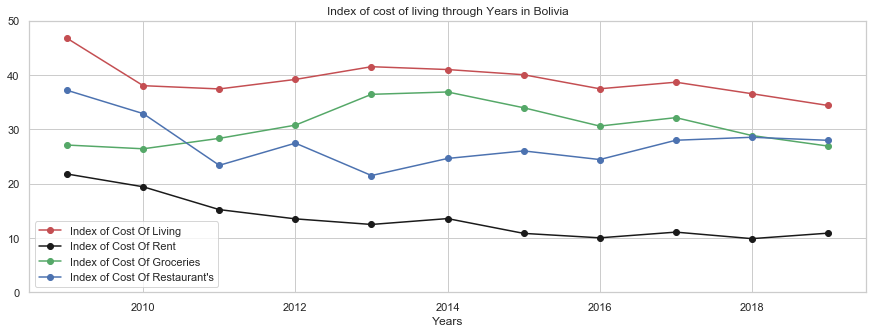

In [500]:
plt.figure(figsize=(15,5))
plt.plot('Year','Cost of Living Index','ro-', data = boliviaOnlyFiltered , label = 'Index of Cost Of Living')
plt.plot('Year','Rent Index', 'ko-', data = boliviaOnlyFiltered, label = 'Index of Cost Of Rent')
plt.plot('Year','Groceries Index', 'go-',data = boliviaOnlyFiltered, label = 'Index of Cost Of Groceries')
plt.plot('Year','Restaurant Price Index', 'bo-' ,data = boliviaOnlyFiltered, label = "Index of Cost Of Restaurant's")
plt.title('Index of cost of living through Years in Bolivia')
plt.xlabel('Years')
plt.ylim(0,50)
plt.legend()
plt.show()

### Bolivia Vs The World

Get the index of living of all the countries stored before

In [954]:
dfBoliviaVsWold = dfBoliviaCostLiving
dfBoliviaVsWold = dfBoliviaVsWold.drop_duplicates().reset_index(drop=True)
dfBoliviaVsWold.drop(labels=['Rank','Cost of Living Plus Rent Index','Local Purchasing Power Index',
                             'Rent Index','Groceries Index','Restaurant Price Index'], axis=1,inplace = True)
dfBoliviaVsWold.head()

,Year,Country,Cost of Living Index
0,2009,Ireland,126.05
1,2009,Netherlands,123.76
2,2009,France,120.92
3,2009,Belgium,117.53
4,2009,Sweden,112.54


1st Analisis, Bolivia and South America : Filter the data for show the countries in South America

In [955]:
southAmericaData  = dfBoliviaVsWold.query("Country in ['Argentina','Bolivia','Brasil','Chile','Colombia','Ecuador','Guyana','Paraguay','Perú','Surinam','Uruguay','Venezuela']")

Plot the information

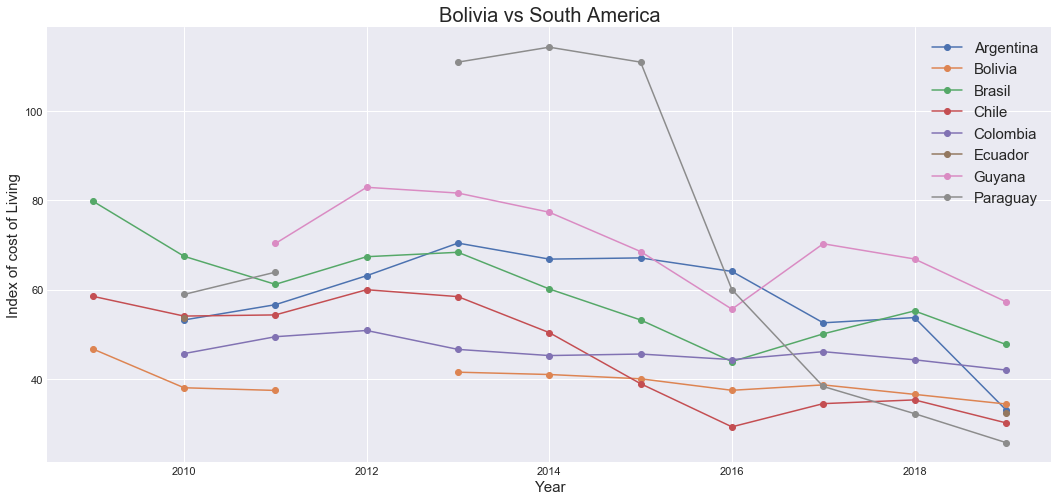

In [982]:
dfSpagghetti = southAmericaData.pivot(index='Year', columns='Country', values='Cost of Living Index')
dfSpagghetti.head()

plt.figure(figsize = (18, 8))
plt.plot(dfSpagghetti,'-o')
plt.ylabel('Index of cost of Living', size = 15)
plt.xlabel('Year', size = 15)
plt.title('Bolivia vs South America', size=20)
plt.legend(['Argentina','Bolivia','Brasil','Chile','Colombia','Ecuador','Guyana',
            'Paraguay','Perú','Surinam','Uruguay','Venezuela'], prop={'size': 15})

### Bolivia vs Europe

2nd Analysis : Get the information of some countries in Europe and Bolivia

In [980]:
boliviaAndEuropeData  = dfBoliviaVsWold.query("Country in ['Bolivia','France','Netherlands','Italy','Germany','United Kingdom','Spain','Portugal']")

Plot the values

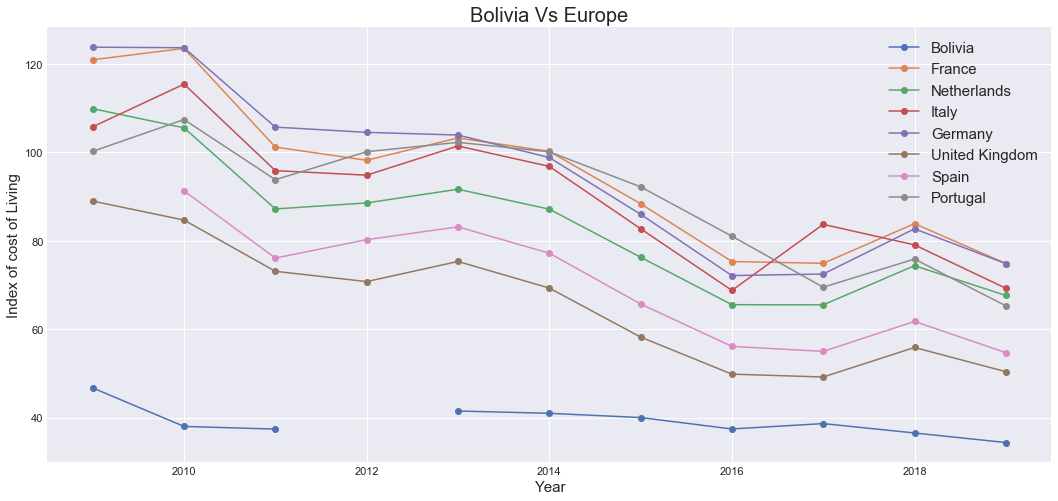

In [1227]:
dfSpagghettiEurope = boliviaAndEuropeData.pivot(index='Year', columns='Country', values='Cost of Living Index')
dfSpagghettiEurope.head()

plt.figure(figsize = (18, 8))
plt.plot(dfSpagghettiEurope,'-o')
plt.ylabel('Index of cost of Living', size = 15)
plt.xlabel('Year', size = 15)
plt.title('Bolivia Vs Europe', size=20)
plt.legend(['Bolivia','France','Netherlands','Italy','Germany','United Kingdom','Spain','Portugal'], prop={'size': 15})

#### Analisys for the most popular cities on Bolivia between cities around the world

Extraction of data with web scrapping from Numbeo

I choose for the analysis the capitals of every country in South America, Europe and Africa, plus some important cities in South America

In [991]:
#List of cities to make the comparison in format required by Numbeo
capitals = ['La-Paz','Cochabamba','Santa-Cruz-Bolivia','Brasilia','Santiago','Bogota','Quito','Georgetown','Asuncion','Lima',
            'Paramaribo','Montevideo','Caracas','Belmopan','Guatemala-City','San-Salvador','Tegucigalpa','Managua',
            'San-Jose-Costa-Rica','Panama-City','Tirana','Berlin','Vienna','Baku','Brussels','Minsk','Sarajevo',
            'Sofia','Nicosia','Zagreb','Copenhagen','Bratislava','Madrid','Tallinn','Moscow','Helsinki','Paris',
            'Athens','Budapest','Dublin','Rome','Astana','Riga','Vilnius','Luxembourg','Skopje',
            'Chisinau','Monaco','Podgorica','Oslo','Amsterdam','Lisbon','London','Prague',
            'Belgrade','Stockholm','Kiev','Rio-De-Janeiro','Sao-Paulo','Cartagena','Cordoba','Mendoza-Argentina','Rosario',
            'La-Plata-Argentina','Salvador','Fortaleza','Iquique-Chile','Antofagasta-Chile','Medellin','Barranquilla',
            'Bucaramanga','Guayaquil','Ambato-Ecuador','Ibarra-Ecuador','Loja','Arequipa-Peru','Chiclayo-Peru','Cusco-Peru',
            'Miraflores-Peru','Tacna-Peru','Nairobi','Cape-Town','Johannesburg','Lagos','Durban','Cairo-Egypt','Pretoria',
            'Casablanca','Alexandria','Algiers','Tunis']
#URL for web scrapping
urlCostLivingCity = 'https://www.numbeo.com/cost-of-living/in/{}?displayCurrency=USD'
frame = []
#Iterate through all cities
for city in capitals:
    df  = ExtractDataPerCity(urlCostLivingCity.format(city),city)
    frame.append(df)

In [1230]:
#Merge all data in a single dataFrame with all features
mergedData = pd.concat(frame, sort=False)
mergedData = mergedData.reset_index(drop=True)
mergedData.head()

,Longitude,Latitude,City,"Meal, Inexpensive Restaurant","Meal for 2 People, Mid-range Restaurant, Three-course",McMeal at McDonalds (or Equivalent Combo Meal),Domestic Beer (0.5 liter draught),Imported Beer (0.33 liter bottle),Cappuccino (regular),Coke/Pepsi (0.33 liter bottle),...,1 Pair of Nike Running Shoes (Mid-Range),1 Pair of Men Leather Business Shoes,Apartment (1 bedroom) in City Centre,Apartment (1 bedroom) Outside of Centre,Apartment (3 bedrooms) in City Centre,Apartment (3 bedrooms) Outside of Centre,Price per Square Meter to Buy Apartment in City Centre,Price per Square Meter to Buy Apartment Outside of Centre,Average Monthly Net Salary (After Tax),"Mortgage Interest Rate in Percentages (%), Yearly, for 20 Years Fixed-Rate"
0,-68.133623,-16.495545,La-Paz,3.63,24.69,5.9,2.18,3.31,2.58,0.89,...,69.72,68.49,333.5,246.92,587.73,555.69,1261.23,921.6,472.24,7.25
1,-66.156959,-17.393585,Cochabamba,3.01,17.43,5.08,2.18,3.01,1.95,0.73,...,65.85,49.26,331.65,194.87,572.28,346.17,902.87,644.9,333.3,7.5
2,-61.500000,-17.333333,Santa-Cruz-Bolivia,3.2,21.26,6.54,1.88,2.9,2.42,0.83,...,87.34,72.83,368.57,262.66,715.48,538.56,1174.08,829.65,605.45,6.5
3,-53.200000,-10.333333,Brasilia,7.47,31.57,6.7,2.06,3.87,1.73,1.15,...,84.44,68.8,367.38,227.6,933.43,593.86,2447.4,1505.63,841.72,9.73
4,-70.650445,-33.437797,Santiago,8.65,43.23,6.48,3.6,4.32,2.72,1.14,...,61.38,83.3,467.23,411.26,852.43,759.38,2419.1,2140.84,829.38,4


Method for extract data, add latitude, longitude and the respective city

In [758]:
def ExtractDataPerCity(url,city):
    df = pd.DataFrame(columns= ['0','1'])
    request = requests.get(url)
    requestSoup = BeautifulSoup(request.text, "html5lib")
    for tag in requestSoup.find_all('table'):
        rows = tag.find_all('tr')
        for row in rows:
            cols = row.find_all('td')
            cols = [ele.text.strip() for ele in cols]
            if (len(cols)!=0):
                if (cols[0] != ''):
                    if (len(cols)>2):
                        #Create temporal table because the format of the data are filled on the rows
                        df = df.append({
                        '0':cols[0],
                        '1':float(cols[1].replace('\xa0$','').replace(',','').replace('?','0'))
                        }, ignore_index=True)
    #Invert the table to
    df = df.T
    #Set the head of the table
    df = df.rename(columns=df.iloc[0])
    #Clean data
    df.drop(df.index[0],inplace=True)
    #Insert the name of the cities
    df.insert(loc=0, column='City', value=city)
    #Search for every location
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(city)
    latitude = location.latitude
    longitude = location.longitude
    #Insert latitude and longitude of every city in the query
    df.insert(loc=0, column='Latitude', value=latitude)
    df.insert(loc=0, column='Longitude', value=longitude)
    return df

In [993]:
#Extract the value of column city to merge later
cities_list =mergedData.City

### K- CLuster Analysis

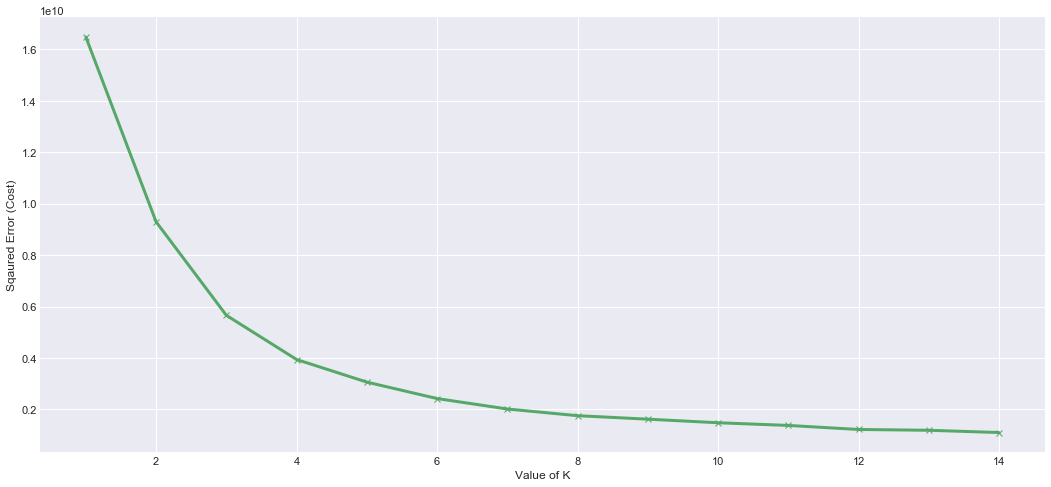

In [1252]:
cost =[] 
for i in range(1, 15): 
    KM = KMeans(n_clusters=i, random_state=0).fit(capital_grouped_clustering)      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.figure(figsize = (18, 8))
plt.plot(range(1, 15), cost, 'x-', color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 


In [1253]:
# set number of clusters
kclusters = 5

capital_grouped_clustering = mergedData.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(capital_grouped_clustering)

# check cluster labels generated 15 for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 2, 0, 0, 3, 0, 0, 0])

In [1254]:
# add clustering labels
capital_grouped_clustering.insert(loc = 0, column = 'Cluster Labels', value = kmeans.labels_)

In [1255]:
# add cities
capital_grouped_clustering.insert(loc = 0, column = 'City', value = cities_list)

In [1256]:
capital_grouped_clustering.head()

,City,Cluster Labels,Longitude,Latitude,"Meal, Inexpensive Restaurant","Meal for 2 People, Mid-range Restaurant, Three-course",McMeal at McDonalds (or Equivalent Combo Meal),Domestic Beer (0.5 liter draught),Imported Beer (0.33 liter bottle),Cappuccino (regular),...,1 Pair of Nike Running Shoes (Mid-Range),1 Pair of Men Leather Business Shoes,Apartment (1 bedroom) in City Centre,Apartment (1 bedroom) Outside of Centre,Apartment (3 bedrooms) in City Centre,Apartment (3 bedrooms) Outside of Centre,Price per Square Meter to Buy Apartment in City Centre,Price per Square Meter to Buy Apartment Outside of Centre,Average Monthly Net Salary (After Tax),"Mortgage Interest Rate in Percentages (%), Yearly, for 20 Years Fixed-Rate"
0,La-Paz,0,-68.133623,-16.495545,3.63,24.69,5.9,2.18,3.31,2.58,...,69.72,68.49,333.5,246.92,587.73,555.69,1261.23,921.6,472.24,7.25
1,Cochabamba,0,-66.156959,-17.393585,3.01,17.43,5.08,2.18,3.01,1.95,...,65.85,49.26,331.65,194.87,572.28,346.17,902.87,644.9,333.3,7.5
2,Santa-Cruz-Bolivia,0,-61.500000,-17.333333,3.2,21.26,6.54,1.88,2.9,2.42,...,87.34,72.83,368.57,262.66,715.48,538.56,1174.08,829.65,605.45,6.5
3,Brasilia,2,-53.200000,-10.333333,7.47,31.57,6.7,2.06,3.87,1.73,...,84.44,68.8,367.38,227.6,933.43,593.86,2447.4,1505.63,841.72,9.73
4,Santiago,0,-70.650445,-33.437797,8.65,43.23,6.48,3.6,4.32,2.72,...,61.38,83.3,467.23,411.26,852.43,759.38,2419.1,2140.84,829.38,4


In [1257]:
# create map
map_clusters = folium.Map(zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(capital_grouped_clustering['Latitude'], capital_grouped_clustering['Longitude'], capital_grouped_clustering['City'], capital_grouped_clustering['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(int(cluster)), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Locate La Paz, Cochabamba and Santa Cruz

In [1258]:
capital_grouped_clustering[capital_grouped_clustering['City']=='La-Paz']

,City,Cluster Labels,Longitude,Latitude,"Meal, Inexpensive Restaurant","Meal for 2 People, Mid-range Restaurant, Three-course",McMeal at McDonalds (or Equivalent Combo Meal),Domestic Beer (0.5 liter draught),Imported Beer (0.33 liter bottle),Cappuccino (regular),...,1 Pair of Nike Running Shoes (Mid-Range),1 Pair of Men Leather Business Shoes,Apartment (1 bedroom) in City Centre,Apartment (1 bedroom) Outside of Centre,Apartment (3 bedrooms) in City Centre,Apartment (3 bedrooms) Outside of Centre,Price per Square Meter to Buy Apartment in City Centre,Price per Square Meter to Buy Apartment Outside of Centre,Average Monthly Net Salary (After Tax),"Mortgage Interest Rate in Percentages (%), Yearly, for 20 Years Fixed-Rate"
0,La-Paz,0,-68.133623,-16.495545,3.63,24.69,5.9,2.18,3.31,2.58,...,69.72,68.49,333.5,246.92,587.73,555.69,1261.23,921.6,472.24,7.25


In [1259]:
capital_grouped_clustering[capital_grouped_clustering['City']=='Santa-Cruz-Bolivia']

,City,Cluster Labels,Longitude,Latitude,"Meal, Inexpensive Restaurant","Meal for 2 People, Mid-range Restaurant, Three-course",McMeal at McDonalds (or Equivalent Combo Meal),Domestic Beer (0.5 liter draught),Imported Beer (0.33 liter bottle),Cappuccino (regular),...,1 Pair of Nike Running Shoes (Mid-Range),1 Pair of Men Leather Business Shoes,Apartment (1 bedroom) in City Centre,Apartment (1 bedroom) Outside of Centre,Apartment (3 bedrooms) in City Centre,Apartment (3 bedrooms) Outside of Centre,Price per Square Meter to Buy Apartment in City Centre,Price per Square Meter to Buy Apartment Outside of Centre,Average Monthly Net Salary (After Tax),"Mortgage Interest Rate in Percentages (%), Yearly, for 20 Years Fixed-Rate"
2,Santa-Cruz-Bolivia,0,-61.5,-17.333333,3.2,21.26,6.54,1.88,2.9,2.42,...,87.34,72.83,368.57,262.66,715.48,538.56,1174.08,829.65,605.45,6.5


In [1260]:
capital_grouped_clustering[capital_grouped_clustering['City']=='Cochabamba']

,City,Cluster Labels,Longitude,Latitude,"Meal, Inexpensive Restaurant","Meal for 2 People, Mid-range Restaurant, Three-course",McMeal at McDonalds (or Equivalent Combo Meal),Domestic Beer (0.5 liter draught),Imported Beer (0.33 liter bottle),Cappuccino (regular),...,1 Pair of Nike Running Shoes (Mid-Range),1 Pair of Men Leather Business Shoes,Apartment (1 bedroom) in City Centre,Apartment (1 bedroom) Outside of Centre,Apartment (3 bedrooms) in City Centre,Apartment (3 bedrooms) Outside of Centre,Price per Square Meter to Buy Apartment in City Centre,Price per Square Meter to Buy Apartment Outside of Centre,Average Monthly Net Salary (After Tax),"Mortgage Interest Rate in Percentages (%), Yearly, for 20 Years Fixed-Rate"
1,Cochabamba,0,-66.156959,-17.393585,3.01,17.43,5.08,2.18,3.01,1.95,...,65.85,49.26,331.65,194.87,572.28,346.17,902.87,644.9,333.3,7.5


In this case La Paz and Santa Cruz are in Cluster 0 and Cochabamba in Cluster 5

#### Cluster 0

In [1261]:
capital_grouped_clustering.loc[capital_grouped_clustering['Cluster Labels'] == 0, capital_grouped_clustering.columns[[0] + list(range(5, capital_grouped_clustering.shape[1]))]]

,City,"Meal for 2 People, Mid-range Restaurant, Three-course",McMeal at McDonalds (or Equivalent Combo Meal),Domestic Beer (0.5 liter draught),Imported Beer (0.33 liter bottle),Imported Beer (0.33 liter bottle),Cappuccino (regular),Coke/Pepsi (0.33 liter bottle),Water (0.33 liter bottle),"Milk (regular), (1 liter)",...,1 Pair of Nike Running Shoes (Mid-Range),1 Pair of Men Leather Business Shoes,Apartment (1 bedroom) in City Centre,Apartment (1 bedroom) Outside of Centre,Apartment (3 bedrooms) in City Centre,Apartment (3 bedrooms) Outside of Centre,Price per Square Meter to Buy Apartment in City Centre,Price per Square Meter to Buy Apartment Outside of Centre,Average Monthly Net Salary (After Tax),"Mortgage Interest Rate in Percentages (%), Yearly, for 20 Years Fixed-Rate"
0,La-Paz,24.69,5.9,2.18,3.31,2.03,2.58,0.89,0.92,0.91,...,69.72,68.49,333.5,246.92,587.73,555.69,1261.23,921.6,472.24,7.25
1,Cochabamba,17.43,5.08,2.18,3.01,2.54,1.95,0.73,0.71,0.87,...,65.85,49.26,331.65,194.87,572.28,346.17,902.87,644.9,333.3,7.5
2,Santa-Cruz-Bolivia,21.26,6.54,1.88,2.9,2.18,2.42,0.83,0.77,1.07,...,87.34,72.83,368.57,262.66,715.48,538.56,1174.08,829.65,605.45,6.5
4,Santiago,43.23,6.48,3.6,4.32,2.1,2.72,1.14,0.97,1.15,...,61.38,83.3,467.23,411.26,852.43,759.38,2419.1,2140.84,829.38,4
5,Bogota,19.86,4.85,1.06,2.12,1.61,1.21,0.75,0.6,0.84,...,76.91,67.44,372.5,264.11,653.67,452.67,1819.94,1276.52,318.44,11.88
7,Georgetown,35.95,5.75,1.44,2.4,2.18,2.64,0.98,0.64,1.89,...,63.26,53.4,207.68,119.82,426.55,263.6,5031.35,3203.12,379.86,8.5
8,Asuncion,23.93,4.47,0.96,1.6,1.25,1.57,0.74,0.46,0.75,...,76.73,56.28,238.68,186.15,581.67,484,989.28,503.58,349.18,14.08
9,Lima,29.96,5.09,2.02,3.6,2.97,2.32,0.76,0.51,1.29,...,73.49,74.16,474.58,289.85,807.2,564.47,1808.04,1194.71,469.93,9.82
14,Guatemala-City,27.63,5.2,1.95,3.25,2.37,2.24,1.1,0.76,1.43,...,89.45,88.61,501.72,316.54,918.85,505.59,1706.27,885.99,590.04,7.68
15,San-Salvador,30,6,2,3,1.5,2.53,0.83,0.74,1.48,...,73.33,80,469.44,444.44,870,895.45,1380,1340,452.61,8.64


#### Cluster 5

In [1006]:
capital_grouped_clustering.loc[capital_grouped_clustering['Cluster Labels'] == 5, capital_grouped_clustering.columns[[0] + list(range(5, capital_grouped_clustering.shape[1]))]]

,City,"Meal for 2 People, Mid-range Restaurant, Three-course",McMeal at McDonalds (or Equivalent Combo Meal),Domestic Beer (0.5 liter draught),Imported Beer (0.33 liter bottle),Imported Beer (0.33 liter bottle),Cappuccino (regular),Coke/Pepsi (0.33 liter bottle),Water (0.33 liter bottle),"Milk (regular), (1 liter)",...,1 Pair of Nike Running Shoes (Mid-Range),1 Pair of Men Leather Business Shoes,Apartment (1 bedroom) in City Centre,Apartment (1 bedroom) Outside of Centre,Apartment (3 bedrooms) in City Centre,Apartment (3 bedrooms) Outside of Centre,Price per Square Meter to Buy Apartment in City Centre,Price per Square Meter to Buy Apartment Outside of Centre,Average Monthly Net Salary (After Tax),"Mortgage Interest Rate in Percentages (%), Yearly, for 20 Years Fixed-Rate"
1,Cochabamba,17.43,5.08,2.18,3.01,2.54,1.95,0.73,0.71,0.87,...,65.85,49.26,331.65,194.87,572.28,346.17,902.87,644.9,333.3,7.5
4,Santiago,43.23,6.48,3.6,4.32,2.1,2.72,1.14,0.97,1.15,...,61.38,83.3,467.23,411.26,852.43,759.38,2419.1,2140.84,829.38,4
5,Bogota,19.86,4.85,1.06,2.12,1.61,1.21,0.75,0.6,0.84,...,76.91,67.44,372.5,264.11,653.67,452.67,1819.94,1276.52,318.44,11.88
7,Georgetown,35.95,5.75,1.44,2.4,2.18,2.64,0.98,0.64,1.89,...,63.26,53.4,207.68,119.82,426.55,263.6,5031.35,3203.12,379.86,8.5
14,Guatemala-City,27.63,5.2,1.95,3.25,2.37,2.24,1.1,0.76,1.43,...,89.45,88.61,501.72,316.54,918.85,505.59,1706.27,885.99,590.04,7.68
15,San-Salvador,30,6,2,3,1.5,2.53,0.83,0.74,1.48,...,73.33,80,469.44,444.44,870,895.45,1380,1340,452.61,8.64
16,Tegucigalpa,20.6,6,1.44,2.06,2,1.33,0.82,0.74,1.09,...,82.06,85.89,359.67,312.74,548.18,548.09,1082.28,770,461.4,10.4
20,Tirana,27.63,4.6,1.38,1.84,1.3,1.32,1.15,0.56,1.21,...,83.71,110.03,327.52,194.67,628.17,339.78,1759.48,767.66,382.29,5.3
45,Skopje,18.32,3.66,1.83,2.2,1.07,1.49,1.41,0.88,0.93,...,76.47,81.86,252.26,180.46,423.09,305.38,1382.03,990.71,428.45,5.67
46,Chisinau,22.15,4.43,1.11,1.58,1.36,1.36,0.64,0.45,0.65,...,87.58,94.47,255.96,186.19,412.37,333.35,919.43,598.17,297.73,10.96


### Venues Analysis for cities in Bolivia

For Santa Cruz city we obtain data from [Santa Cruz web Page](http://www.concejomunicipalscz.gob.bo/jurisdiccion-territorial/distritos-municipales.php#seccion-distrito-municipal-01)

In [1028]:
#Data for all districtis in Santa Cruz
santaCruzDistricts = ['Pirai','Norte Integrado','Estación Argentina','El Pari','Norte','Carretera Cotoca','Villa 1ro de Mayo',
                 'Plan 3000','Palmasola','El Bajío','Central','Nuevo Palmar']
santaCruzPopByDistrict = [112642,83000,76000,74000,200000,212272,165015,320000,130000,200000,163000,46818]
santaCruzLatDistrict = ['-17.767868','-17.767726','-17.804731','-17.808836','-17.729472','-17.754687','-17.795214','-17.832799',
                        '-17.845584','-17.827349','-17.783307','-17.854135',]
santaCruzLongDistrict = ['-63.198589','-63.158181','-63.154902','-63.193901','-63.161272','-63.112317','-63.139007','-63.113251',
                         '-63.194094','-63.225599','-63.182138','-63.166089',]
dfSantaCruzDistricts = pd.DataFrame(columns = ['City','District','Population','Latitude','Longitude'])
#Fill data frame Data
dfSantaCruzDistricts.District = santaCruzDistricts
dfSantaCruzDistricts.Population = santaCruzPopByDistrict
dfSantaCruzDistricts.City = 'Santa Cruz'
dfSantaCruzDistricts.Latitude = santaCruzLatDistrict
dfSantaCruzDistricts.Longitude = santaCruzLongDistrict
dfSantaCruzDistricts

,City,District,Population,Latitude,Longitude
0,Santa Cruz,Pirai,112642,-17.767868,-63.198589
1,Santa Cruz,Norte Integrado,83000,-17.767726,-63.158181
2,Santa Cruz,Estación Argentina,76000,-17.804731,-63.154902
3,Santa Cruz,El Pari,74000,-17.808836,-63.193901
4,Santa Cruz,Norte,200000,-17.729472,-63.161272
5,Santa Cruz,Carretera Cotoca,212272,-17.754687,-63.112317
6,Santa Cruz,Villa 1ro de Mayo,165015,-17.795214,-63.139007
7,Santa Cruz,Plan 3000,320000,-17.832799,-63.113251
8,Santa Cruz,Palmasola,130000,-17.845584,-63.194094
9,Santa Cruz,El Bajío,200000,-17.827349,-63.225599


For La Paz districts I obtained data from [La Paz Web Site](https://www.lapaz.bo/gobierno/subalcaldias/) and [Wikipedia](https://es.wikipedia.org/wiki/Gobierno_Aut%C3%B3nomo_Municipal_de_La_Paz)

In [1030]:
#Data for all districtis in Santa Cruz
laPazDistricts = ['Cotahuma','Max Paredes','Periférica','San Antonio','Sur','Mallasa','Centro']
laPazPopByDistrict = [180944, 164566 ,159123,115659,127228,5082,73546]
laPazLatDistrict = ['-16.519409','-16.487046','-16.497137','-16.499602','-16.531502','-16.573319','-16.502435']
laPazLongDistrict = ['-68.134965','-68.156138','-68.088500','-68.107819','-68.075332','-68.081011','-68.123535']
dfLaPazDistricts = pd.DataFrame(columns = ['City','District','Population','Latitude','Longitude'])
#Fill data frame Data
dfLaPazDistricts.District = laPazDistricts
dfLaPazDistricts.Population = laPazPopByDistrict
dfLaPazDistricts.City = 'La Paz'
dfLaPazDistricts.Latitude = laPazLatDistrict
dfLaPazDistricts.Longitude = laPazLongDistrict
dfLaPazDistricts

,City,District,Population,Latitude,Longitude
0,La Paz,Cotahuma,180944,-16.519409,-68.134965
1,La Paz,Max Paredes,164566,-16.487046,-68.156138
2,La Paz,Periférica,159123,-16.497137,-68.088500
3,La Paz,San Antonio,115659,-16.499602,-68.107819
4,La Paz,Sur,127228,-16.531502,-68.075332
5,La Paz,Mallasa,5082,-16.573319,-68.081011
6,La Paz,Centro,73546,-16.502435,-68.123535


Unfortunately there is no exists the same information for Cochabamba city, the analysis will made on the available data

In [1222]:
#Merge data from this two cities
boliviaFrames = [dfLaPazDistricts,dfSantaCruzDistricts]
popularCitiesBolivia = pd.concat(boliviaFrames)
popularCitiesBolivia

,City,District,Population,Latitude,Longitude
0,La Paz,Cotahuma,180944,-16.519409,-68.134965
1,La Paz,Max Paredes,164566,-16.487046,-68.156138
2,La Paz,Periférica,159123,-16.497137,-68.088500
3,La Paz,San Antonio,115659,-16.499602,-68.107819
4,La Paz,Sur,127228,-16.531502,-68.075332
5,La Paz,Mallasa,5082,-16.573319,-68.081011
6,La Paz,Centro,73546,-16.502435,-68.123535
0,Santa Cruz,Pirai,112642,-17.767868,-63.198589
1,Santa Cruz,Norte Integrado,83000,-17.767726,-63.158181
2,Santa Cruz,Estación Argentina,76000,-17.804731,-63.154902


In [1223]:
#Function for obtain information from Foursquare
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [1131]:
CLIENT_ID = 'NVNCOJV0OSRMQGY01RZAQBZAVJOLC4Q4XI0PNWRPZQKRDRRM' # your Foursquare ID
CLIENT_SECRET = 'XURZFAEPJD3KRRV3JMVNH3KPEAYBNFDMAUCUNYU4S1WF1IUO' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100
radius = 5000 # define radius

In [1224]:
#Find Venues in different cities from Bolivia
bolivia_venues = getNearbyVenues(names=popularCitiesBolivia['District'],
                                   latitudes=popularCitiesBolivia['Latitude'],
                                   longitudes=popularCitiesBolivia['Longitude'])

Cotahuma
Max Paredes
Periférica
San Antonio
Sur
Mallasa
Centro
Pirai
Norte Integrado
Estación Argentina
El Pari
Norte
Carretera Cotoca
Villa 1ro de Mayo
Plan 3000
Palmasola
El Bajío
Central
Nuevo Palmar


In [1133]:
bolivia_venues.groupby('District').count()

,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
Central,42,42,42,42,42,42
Centro,18,18,18,18,18,18
Cotahuma,3,3,3,3,3,3
El Bajío,3,3,3,3,3,3
El Pari,4,4,4,4,4,4
Estación Argentina,5,5,5,5,5,5
Mallasa,4,4,4,4,4,4
Max Paredes,3,3,3,3,3,3
Norte,2,2,2,2,2,2


Fix the data, and insert the district 

In [1134]:
# one hot encoding
bolivia_onehot = pd.get_dummies(bolivia_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bolivia_onehot['District'] = bolivia_venues[['District']]

# move neighborhood column to the first column
districtColumn = bolivia_onehot['District']
bolivia_onehot.drop(labels=['District'], axis=1,inplace = True)
bolivia_onehot.insert(0, 'District', districtColumn)

bolivia_onehot.head()

,District,Argentinian Restaurant,Art Gallery,Asian Restaurant,BBQ Joint,Bar,Big Box Store,Bistro,Boat or Ferry,Brazilian Restaurant,...,Snack Place,Soccer Field,Soccer Stadium,Spanish Restaurant,Sporting Goods Shop,Steakhouse,Sushi Restaurant,Swiss Restaurant,Theater,Wings Joint
0,Cotahuma,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Cotahuma,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Cotahuma,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Max Paredes,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Max Paredes,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Group data by district and reset indexes

In [1211]:
bolivia_grouped = bolivia_onehot.groupby('District').mean().reset_index()
bolivia_grouped

,District,Argentinian Restaurant,Art Gallery,Asian Restaurant,BBQ Joint,Bar,Big Box Store,Bistro,Boat or Ferry,Brazilian Restaurant,...,Snack Place,Soccer Field,Soccer Stadium,Spanish Restaurant,Sporting Goods Shop,Steakhouse,Sushi Restaurant,Swiss Restaurant,Theater,Wings Joint
0,Central,0.02381,0.071429,0.000000,0.000000,0.119048,0.000000,0.02381,0.0,0.023810,...,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
1,Centro,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.055556,...,0.00,0.00,0.055556,0.00,0.00,0.000000,0.000000,0.000000,0.055556,0.000000
2,Cotahuma,0.00000,0.000000,0.000000,0.000000,0.000000,0.333333,0.00000,0.0,0.000000,...,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
3,El Bajío,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,...,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
4,El Pari,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,...,0.00,0.00,0.000000,0.00,0.25,0.000000,0.000000,0.000000,0.000000,0.000000
5,Estación Argentina,0.00000,0.000000,0.000000,0.000000,0.200000,0.000000,0.00000,0.0,0.000000,...,0.00,0.00,0.000000,0.00,0.00,0.000000,0.200000,0.000000,0.000000,0.000000
6,Mallasa,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,...,0.00,0.00,0.000000,0.25,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
7,Max Paredes,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,...,0.00,0.00,0.333333,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
8,Norte,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.5,0.000000,...,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
9,Norte Integrado,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,...,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000


### K-Mean Analysis

In [1212]:
# set number of clusters
kclusters = 3

bolivia_grouped_clustering = bolivia_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bolivia_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 2, 0, 0, 0, 0, 0, 0, 0])

In [1213]:
# add clustering labels
#bolivia_grouped.drop(labels=['Cluster Labels'], axis=1,inplace = True)
bolivia_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

bolivia_grouped.head() # check the last columns!

,Cluster Labels,District,Argentinian Restaurant,Art Gallery,Asian Restaurant,BBQ Joint,Bar,Big Box Store,Bistro,Boat or Ferry,...,Snack Place,Soccer Field,Soccer Stadium,Spanish Restaurant,Sporting Goods Shop,Steakhouse,Sushi Restaurant,Swiss Restaurant,Theater,Wings Joint
0,0,Central,0.02381,0.071429,0.0,0.0,0.119048,0.000000,0.02381,0.0,...,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.000000,0.0
1,0,Centro,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.0,...,0.0,0.0,0.055556,0.0,0.00,0.0,0.0,0.0,0.055556,0.0
2,2,Cotahuma,0.00000,0.000000,0.0,0.0,0.000000,0.333333,0.00000,0.0,...,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.000000,0.0
3,0,El Bajío,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.0,...,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.000000,0.0
4,0,El Pari,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.0,...,0.0,0.0,0.000000,0.0,0.25,0.0,0.0,0.0,0.000000,0.0


Add the latitude , longitude and city to the final dataframe

In [1214]:
#bolivia_grouped.drop(labels=['Latitude'], axis=1,inplace = True)
#bolivia_grouped.drop(labels=['Longitude'], axis=1,inplace = True)
bolivia_grouped.insert(loc=0, column='Latitude', value=0)
bolivia_grouped.insert(loc=0, column='Longitude', value=0)
bolivia_grouped.insert(loc=0, column='City', value=0)

Fill the data with the array obtained previously

In [1215]:
for index in range (0 , len(bolivia_grouped)):
    districtFinded = popularCitiesBolivia[popularCitiesBolivia['District'] == bolivia_grouped.loc[index,'District']]
    bolivia_grouped.loc[index,'Latitude'] = float(districtFinded.Latitude.values)
    bolivia_grouped.loc[index,'Longitude'] = float(districtFinded.Longitude.values)
    bolivia_grouped.loc[index,'City'] = districtFinded.City.values
    
bolivia_grouped

,City,Longitude,Latitude,Cluster Labels,District,Argentinian Restaurant,Art Gallery,Asian Restaurant,BBQ Joint,Bar,...,Snack Place,Soccer Field,Soccer Stadium,Spanish Restaurant,Sporting Goods Shop,Steakhouse,Sushi Restaurant,Swiss Restaurant,Theater,Wings Joint
0,Santa Cruz,-63.182138,-17.783307,0,Central,0.02381,0.071429,0.000000,0.000000,0.119048,...,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
1,La Paz,-68.123535,-16.502435,0,Centro,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.055556,0.00,0.00,0.000000,0.000000,0.000000,0.055556,0.000000
2,La Paz,-68.134965,-16.519409,2,Cotahuma,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
3,Santa Cruz,-63.225599,-17.827349,0,El Bajío,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
4,Santa Cruz,-63.193901,-17.808836,0,El Pari,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.000000,0.00,0.25,0.000000,0.000000,0.000000,0.000000,0.000000
5,Santa Cruz,-63.154902,-17.804731,0,Estación Argentina,0.00000,0.000000,0.000000,0.000000,0.200000,...,0.00,0.00,0.000000,0.00,0.00,0.000000,0.200000,0.000000,0.000000,0.000000
6,La Paz,-68.081011,-16.573319,0,Mallasa,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.000000,0.25,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
7,La Paz,-68.156138,-16.487046,0,Max Paredes,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.333333,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
8,Santa Cruz,-63.161272,-17.729472,0,Norte,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
9,Santa Cruz,-63.158181,-17.767726,0,Norte Integrado,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000


In [1226]:
# create map
map_clusters = folium.Map(location=[-16.2901535, -63.5886536], zoom_start=7)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bolivia_grouped['Latitude'], bolivia_grouped['Longitude'], bolivia_grouped['District'], bolivia_grouped['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(int(cluster)), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Check Clusters

#### Cluster 0

In [1220]:
bolivia_grouped.loc[bolivia_grouped['Cluster Labels'] == 0, bolivia_grouped.columns[[0,4] + list(range(5, bolivia_grouped.shape[1]))]]

,City,District,Argentinian Restaurant,Art Gallery,Asian Restaurant,BBQ Joint,Bar,Big Box Store,Bistro,Boat or Ferry,...,Snack Place,Soccer Field,Soccer Stadium,Spanish Restaurant,Sporting Goods Shop,Steakhouse,Sushi Restaurant,Swiss Restaurant,Theater,Wings Joint
0,Santa Cruz,Central,0.02381,0.071429,0.000000,0.000000,0.119048,0.0,0.02381,0.0,...,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
1,La Paz,Centro,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,...,0.00,0.00,0.055556,0.00,0.00,0.000000,0.000000,0.000000,0.055556,0.000000
3,Santa Cruz,El Bajío,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,...,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
4,Santa Cruz,El Pari,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,...,0.00,0.00,0.000000,0.00,0.25,0.000000,0.000000,0.000000,0.000000,0.000000
5,Santa Cruz,Estación Argentina,0.00000,0.000000,0.000000,0.000000,0.200000,0.0,0.00000,0.0,...,0.00,0.00,0.000000,0.00,0.00,0.000000,0.200000,0.000000,0.000000,0.000000
6,La Paz,Mallasa,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,...,0.00,0.00,0.000000,0.25,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
7,La Paz,Max Paredes,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,...,0.00,0.00,0.333333,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
8,Santa Cruz,Norte,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.5,...,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
9,Santa Cruz,Norte Integrado,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,...,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
10,Santa Cruz,Palmasola,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,...,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
